In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from transformers import ZoeDepthForDepthEstimation, ZoeDepthImageProcessor
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def read_rgb(path):
    bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    assert bgr is not None, f"Could not read the image from {path}"
    return cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)


def save_depth_png(depth, out_path, vmax=None):
    if vmax is None:
        vmax = np.percentile(depth[~np.isnan(depth)], 95) if np.any(~np.isnan(depth)) else depth.max()

    x = np.clip(depth / (vmax + 1e-8), 0, 1)
    vis = (x * 255).astype(np.uint8)
    cv2.imwrite(out_path, vis)
    return vis


def visualize_depth(depth):
    H, W = depth.shape[:2]
    step = max(1, min(H, W) // 240)
    Y, X = np.mgrid[0:H:step, 0:W:step]
    Z = depth[::step, ::step]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap='viridis', linewidth=0, antialiased=False)
    ax.set_title("DepthAnything V2 - Depth Surface")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("depth")
    ax.view_init(elev=60, azim=90)
    fig.colorbar(surf, shrink=0.5, aspect=12)
    plt.show()

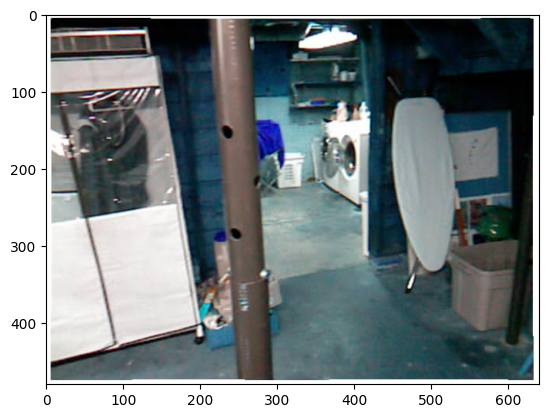

In [3]:
img_path = '/content/Untitled_1.jpeg'

rgb = read_rgb(img_path)
plt.imshow(rgb)
plt.show()

# Chạy inference một số mô hình Depth-Estimation

## Sử dụng mô hình ZoeDepth có sẵn trong Torch

In [4]:
model_id = "Intel/zoedepth-nyu-kitti"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = ZoeDepthImageProcessor.from_pretrained(model_id)
model = ZoeDepthForDepthEstimation.from_pretrained(model_id).to(device).eval()

preprocessor_config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.38G [00:00<?, ?B/s]

In [5]:
H0, W0 = rgb.shape[:2]

inputs = processor(images=rgb, return_tensors="pt").to(next(model.parameters()).device)
with torch.no_grad():
    outputs = model(**inputs)

pred = outputs.predicted_depth
pred_resized = torch.nn.functional.interpolate(pred.unsqueeze(1), size=(H0, W0),
                                               mode="bicubic", align_corners=False).squeeze(1)
depth = pred_resized[0].float().cpu().numpy()
d = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)
gray = (d * 255).astype(np.uint8)
color = cv2.applyColorMap(gray, cv2.COLORMAP_PLASMA)

print(f"Raw predicted depth shape: {tuple(pred.shape)}")
print('Finish predict (H, W) = ', depth.shape)

Raw predicted depth shape: (1, 384, 512)
Finish predict (H, W) =  (480, 640)


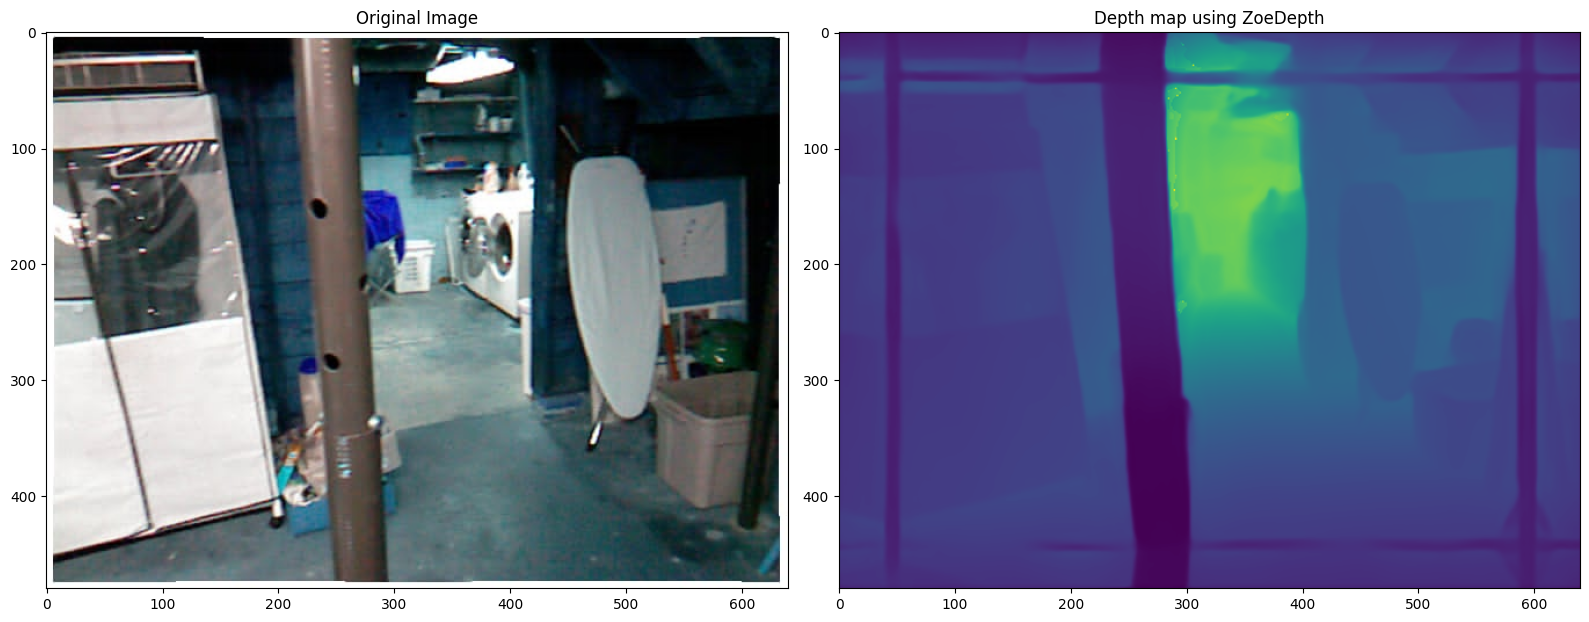

In [6]:
figs, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(rgb)
axes[0].set_title('Original Image')
axes[1].imshow(depth)
axes[1].set_title('Depth map using ZoeDepth')
plt.tight_layout()
plt.show()

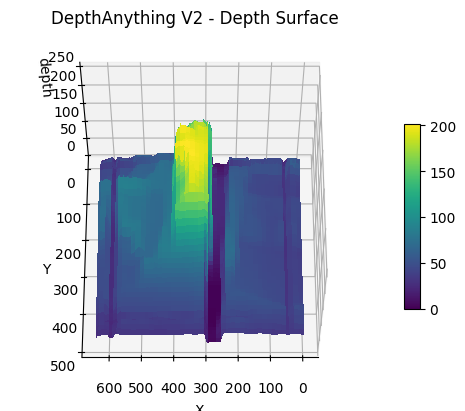

In [7]:
visualize_depth(gray)

## Sử dụng mô hình MiDAS-DPT bằng TorchHub

In [8]:
model_midas = torch.hub.load('intel-isl/MiDaS', 'DPT_Hybrid').to(device).eval()

/usr/local/lib/python3.12/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_base_resnet50_384 to current vit_base_r50_s16_384.orig_in21k_ft_in1k.
  model = create_fn(


Downloading: "https://github.com/isl-org/MiDaS/releases/download/v3/dpt_hybrid_384.pt" to /root/.cache/torch/hub/checkpoints/dpt_hybrid_384.pt


100%|██████████| 470M/470M [00:19<00:00, 24.8MB/s]


In [9]:
transform = torch.hub.load('intel-isl/MiDaS', 'transforms').dpt_transform

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


In [10]:
device_midas = next(model.parameters()).device
t = transform(rgb)
inp = t['image'] if isinstance(t, dict) else t
if inp.ndim == 3:
    inp = inp.unsqueeze(0)
inp = inp.to(device_midas)

with torch.no_grad():
    pred = model_midas(inp)

H, W = rgb.shape[:2]
pred = torch.nn.functional.interpolate(pred.unsqueeze(1), size=(H, W),
                                       mode="bicubic", align_corners=False).squeeze().cpu().numpy()
p = (pred - pred.min()) / (pred.max() - pred.min() + 1e-8)
vis = (p * 255).astype('uint8')

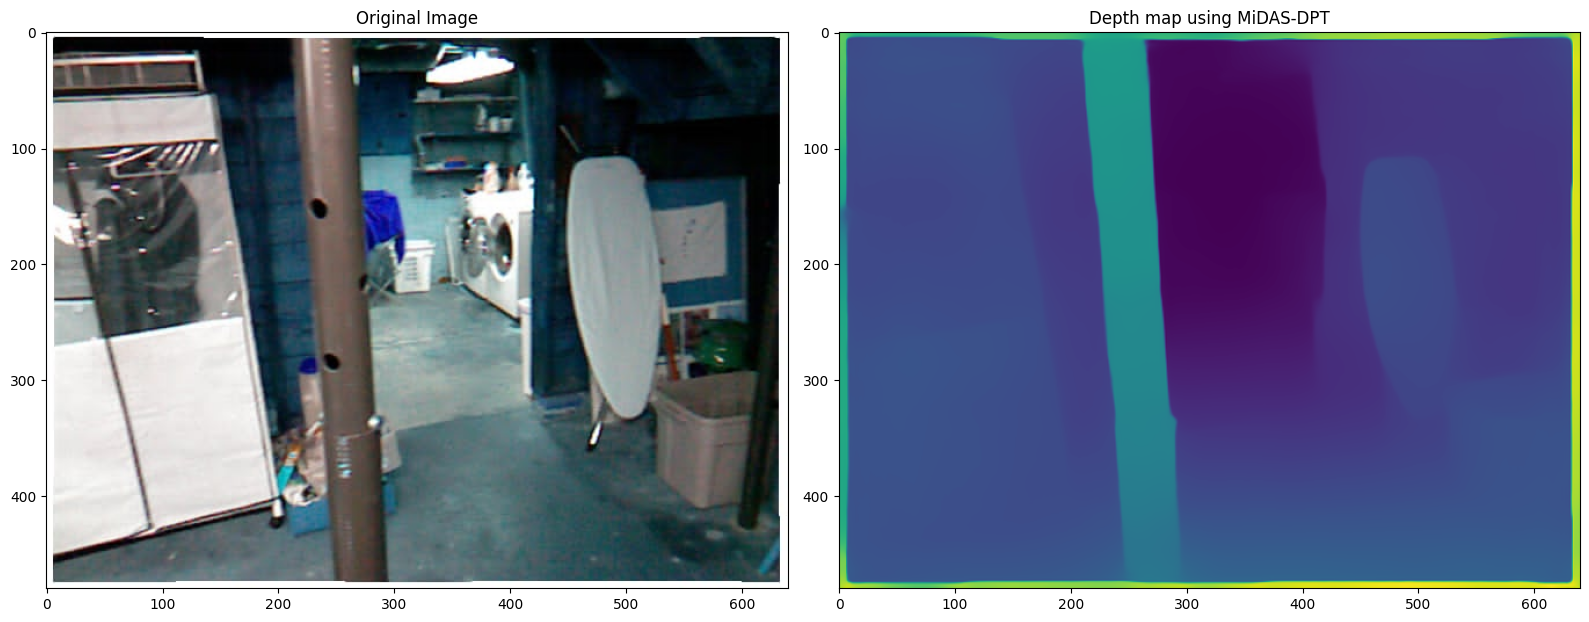

In [11]:
figs, axes = plt.subplots(1, 2, figsize=(16, 8))
axes[0].imshow(rgb)
axes[0].set_title('Original Image')
axes[1].imshow(vis)
axes[1].set_title('Depth map using MiDAS-DPT')
plt.tight_layout()
plt.show()

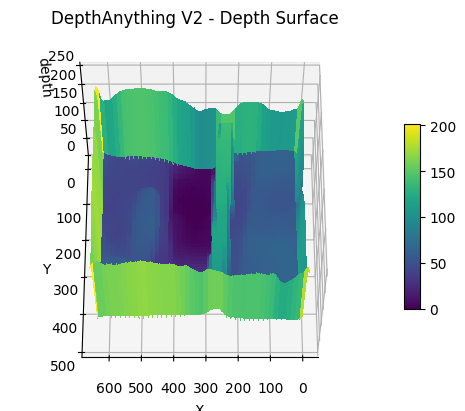

In [12]:
visualize_depth(vis)